# New York Airbnb Analytics

### Data Processing For Group Project

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#Suppress all warning
import warnings
warnings.filterwarnings("ignore")
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


# Get the data

In [106]:
import pandas as pd
df1=pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2021-02-04/data/listings.csv.gz')


In [107]:
df1.head()

id  ... reviews_per_month
0  2595  ...              0.35
1  3831  ...              4.99
2  5121  ...              0.35
3  5178  ...              3.31
4  5203  ...              0.85

[5 rows x 74 columns]

- Pick the valuable columns (not the columns with unique value for each row)

In [108]:
df1.drop(df1.columns[np.r_[0:3,6:10,12,18:22,24,26,34,31,42:55,56,61:68,69:73]], axis=1, inplace=True)

In [109]:
df1.head()

last_scraped  ... reviews_per_month
0   2021-02-05  ...              0.35
1   2021-02-05  ...              4.99
2   2021-02-05  ...              0.35
3   2021-02-05  ...              3.31
4   2021-02-06  ...              0.85

[5 rows x 33 columns]

In [110]:
corr_matrix=df1.corr()
corr_matrix["review_scores_rating"].sort_values(ascending=False)

review_scores_rating         1.000000
number_of_reviews            0.054595
reviews_per_month            0.041548
bedrooms                     0.010334
number_of_reviews_l30d       0.005152
accommodates                -0.006905
beds                        -0.011301
maximum_nights              -0.013451
longitude                   -0.015705
minimum_nights              -0.025785
latitude                    -0.031618
host_total_listings_count   -0.032321
Name: review_scores_rating, dtype: float64

### 2. Clean/ Processing the dataset

In [111]:
#=======================================================Data Cleansing===================================================
#Only pick the Airbnb apartment with reviews
df1=df1[df1['number_of_reviews'].astype(int)>0]
#Only pick the Airbnb apartment with price
df1=df1[df1['price'].apply(lambda x: len(x)>0)]
#Only pick the Airbnb with the answer(t/f) for "host_is_superhost"
df1=df1[df1['host_is_superhost'].apply(lambda x: len(str(x))==1)]
#Drop other answer except f/t in "instant_bookable"
df1=df1[df1['instant_bookable'].isin(['f','t'])]
#To drop the review score which lower than 21 (potential outliers)
df1=df1[df1['review_scores_rating']>21]
#Replace all the blank cell with NaN value
df1=df1.replace('',np.NaN)
#========================================================Add new features===============================================
#Get the length of the sentence in following five columns (number of words)
df1['name_length']  = df1['name'].apply(lambda x: len(str(x).split()))
df1['description_length']=df1['description'].apply(lambda x: len(str(x).split()))
df1['host_about_length']=df1['host_about'].apply(lambda x: len(str(x).split()))
df1['verifications_length']=df1['host_verifications'].apply(lambda x: len(str(x).split(',')))
df1['amenities_length']=df1['amenities'].apply(lambda x: len(str(x).split(',')))
#Get the difference between the "last_scraped" with the following dates (in days)
df1['host_since_days'] = (pd.to_datetime(df1['last_scraped'])-pd.to_datetime(df1['host_since'])).dt.days
df1['first_reviews_days'] = (pd.to_datetime(df1['last_scraped'])-pd.to_datetime(df1['first_review'])).dt.days
df1['last_review_days'] = (pd.to_datetime(df1['last_scraped'])-pd.to_datetime(df1['last_review'])).dt.days

#Convert price column to the float datatype
df1['price'] = df1['price'].str.replace(',', '').str.replace('$', '').astype(float)
#Get the new column to express the price per accommodate
df1['price_per_accommodates']=df1['price']/df1['accommodates'].astype(float)
#=====================================================Change the data type=============================================
#Convert the categorical columns to dummified columns
list_col=['host_is_superhost','host_identity_verified','instant_bookable']
for i in list_col:
    df1[i] = np.where(df1[i]== 't', 1, 0)

In [112]:
#Add the dummified column by extract the word from "amenities" column
df1['has_Hair_dryer']=np.where(df1['amenities'].str.contains('Hair dryer'), 1, 0)
#df[df['date'].astype(str).str.contains('07311954')]


- Apply impute package to fill the missing data in numerical columns

In [113]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [114]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26633 entries, 0 to 36915
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   last_scraped                  26633 non-null  object 
 1   name                          26628 non-null  object 
 2   description                   26174 non-null  object 
 3   host_name                     26633 non-null  object 
 4   host_since                    26633 non-null  object 
 5   host_about                    17074 non-null  object 
 6   host_response_time            13574 non-null  object 
 7   host_response_rate            13574 non-null  object 
 8   host_acceptance_rate          17229 non-null  object 
 9   host_is_superhost             26633 non-null  int64  
 10  host_total_listings_count     26633 non-null  float64
 11  host_verifications            26633 non-null  object 
 12  host_identity_verified        26633 non-null  int64  
 13  n

- Remove the text attribute because median can only be calculated on numerical attributes:

In [122]:
df_num=df1.drop(['neighbourhood_group_cleansed'],axis=1).iloc[:,np.r_[9:11,12,14:16,17,19:21,22:27,29:42]]

In [123]:
sample_incomplete_rows = df_num[df_num.isnull().any(axis=1)].head()

In [124]:
imputer.fit(df_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [125]:
imputer.statistics_

array([ 0.000000e+00,  1.000000e+00,  1.000000e+00,  4.072313e+01,
       -7.395473e+01,  2.000000e+00,  1.000000e+00,  1.000000e+00,
        9.900000e+01,  3.000000e+01,  1.125000e+03,  9.000000e+00,
        0.000000e+00,  9.700000e+01,  0.000000e+00,  3.800000e-01,
        6.000000e+00,  1.420000e+02,  1.300000e+01,  5.000000e+00,
        2.100000e+01,  2.075000e+03,  1.072000e+03,  3.720000e+02,
        4.000000e+01,  1.000000e+00])

In [126]:
df_num.median().values

array([ 0.000000e+00,  1.000000e+00,  1.000000e+00,  4.072313e+01,
       -7.395473e+01,  2.000000e+00,  1.000000e+00,  1.000000e+00,
        9.900000e+01,  3.000000e+01,  1.125000e+03,  9.000000e+00,
        0.000000e+00,  9.700000e+01,  0.000000e+00,  3.800000e-01,
        6.000000e+00,  1.420000e+02,  1.300000e+01,  5.000000e+00,
        2.100000e+01,  2.075000e+03,  1.072000e+03,  3.720000e+02,
        4.000000e+01,  1.000000e+00])

In [127]:
X = imputer.transform(df_num)
df_tr = pd.DataFrame(X, columns=df_num.columns,
                          index=df1.index)
df_tr.loc[sample_incomplete_rows.index.values]

host_is_superhost  ...  has_Hair_dryer
0                 0.0  ...             1.0
6                 0.0  ...             1.0
11                0.0  ...             0.0
13                0.0  ...             0.0
73                0.0  ...             0.0

[5 rows x 26 columns]

In [128]:
imputer.strategy
df_tr = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)
df_tr.head()

host_is_superhost  ...  has_Hair_dryer
0                0.0  ...             1.0
1                0.0  ...             1.0
2                0.0  ...             0.0
3                0.0  ...             1.0
4                0.0  ...             1.0

[5 rows x 26 columns]

In [129]:
#Drop the rows with NaN value for all categorical columns
df1=df1.dropna()

In [132]:
#Convert the object datatype to numerical datatype: host_response_rate, host_acceptance_rate
df1['host_acceptance_rate'] =df1['host_acceptance_rate'].str.replace('%',"").astype(int)/100
df1['host_response_rate'] =df1['host_response_rate'].str.replace('%',"").astype(int)/100

In [133]:
df1.head()

last_scraped  ... has_Hair_dryer
1   2021-02-05  ...              1
3   2021-02-05  ...              1
5   2021-02-05  ...              1
8   2021-02-06  ...              1
9   2021-02-05  ...              1

[5 rows x 43 columns]

### 3. Get the general insight for Airbnb dataset

In [134]:
#get the data type for each column of variable
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7831 entries, 1 to 36848
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   last_scraped                  7831 non-null   object 
 1   name                          7831 non-null   object 
 2   description                   7831 non-null   object 
 3   host_name                     7831 non-null   object 
 4   host_since                    7831 non-null   object 
 5   host_about                    7831 non-null   object 
 6   host_response_time            7831 non-null   object 
 7   host_response_rate            7831 non-null   float64
 8   host_acceptance_rate          7831 non-null   float64
 9   host_is_superhost             7831 non-null   int64  
 10  host_total_listings_count     7831 non-null   float64
 11  host_verifications            7831 non-null   object 
 12  host_identity_verified        7831 non-null   int64  
 13  ne

In [135]:
#Get the statistic value for each numerical columns
df1.describe()

host_response_rate  ...  has_Hair_dryer
count         7831.000000  ...     7831.000000
mean             0.918087  ...        0.807432
std              0.204328  ...        0.394342
min              0.000000  ...        0.000000
25%              0.960000  ...        1.000000
50%              1.000000  ...        1.000000
75%              1.000000  ...        1.000000
max              1.000000  ...        1.000000

[8 rows x 28 columns]

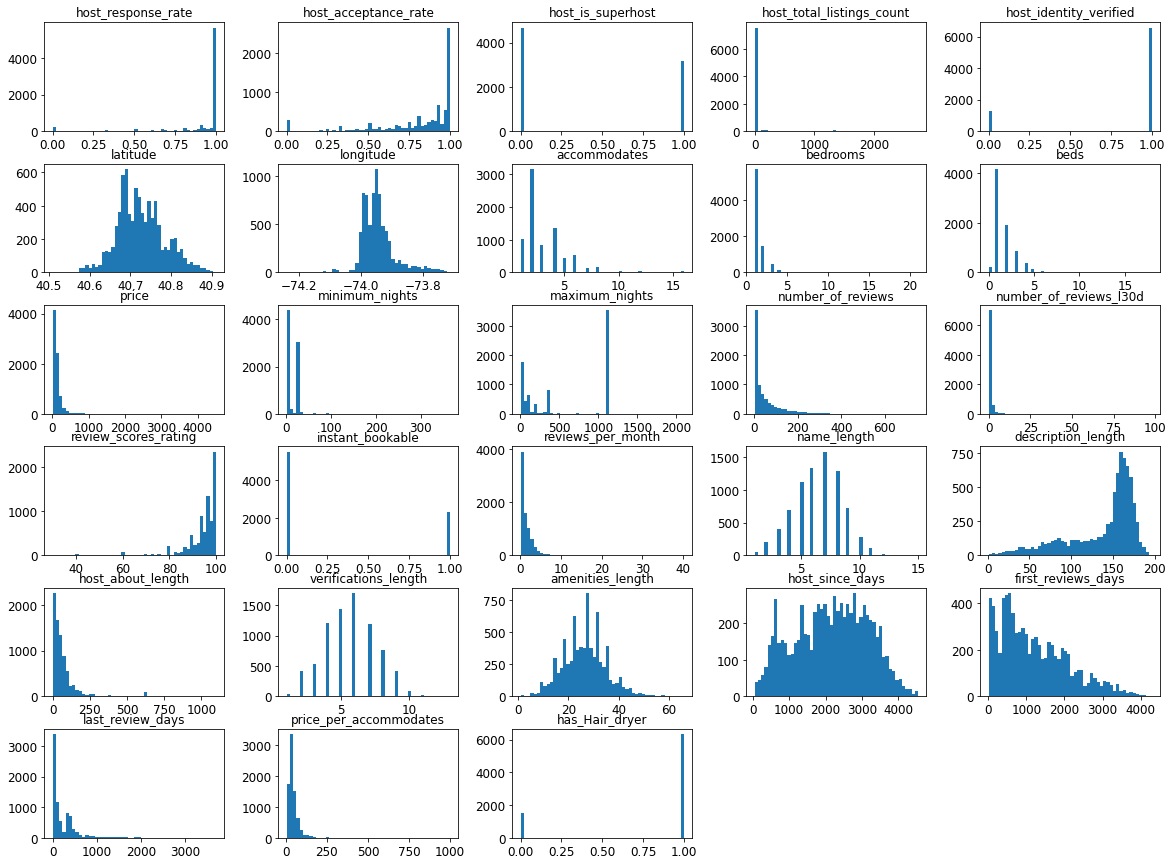

In [ ]:
# Get the numerical columns' distribution
import matplotlib.pyplot as plt
df1.hist(bins=50, figsize=(20,15),grid=False)
plt.savefig("attribute_histogram_plots.png")
plt.show()

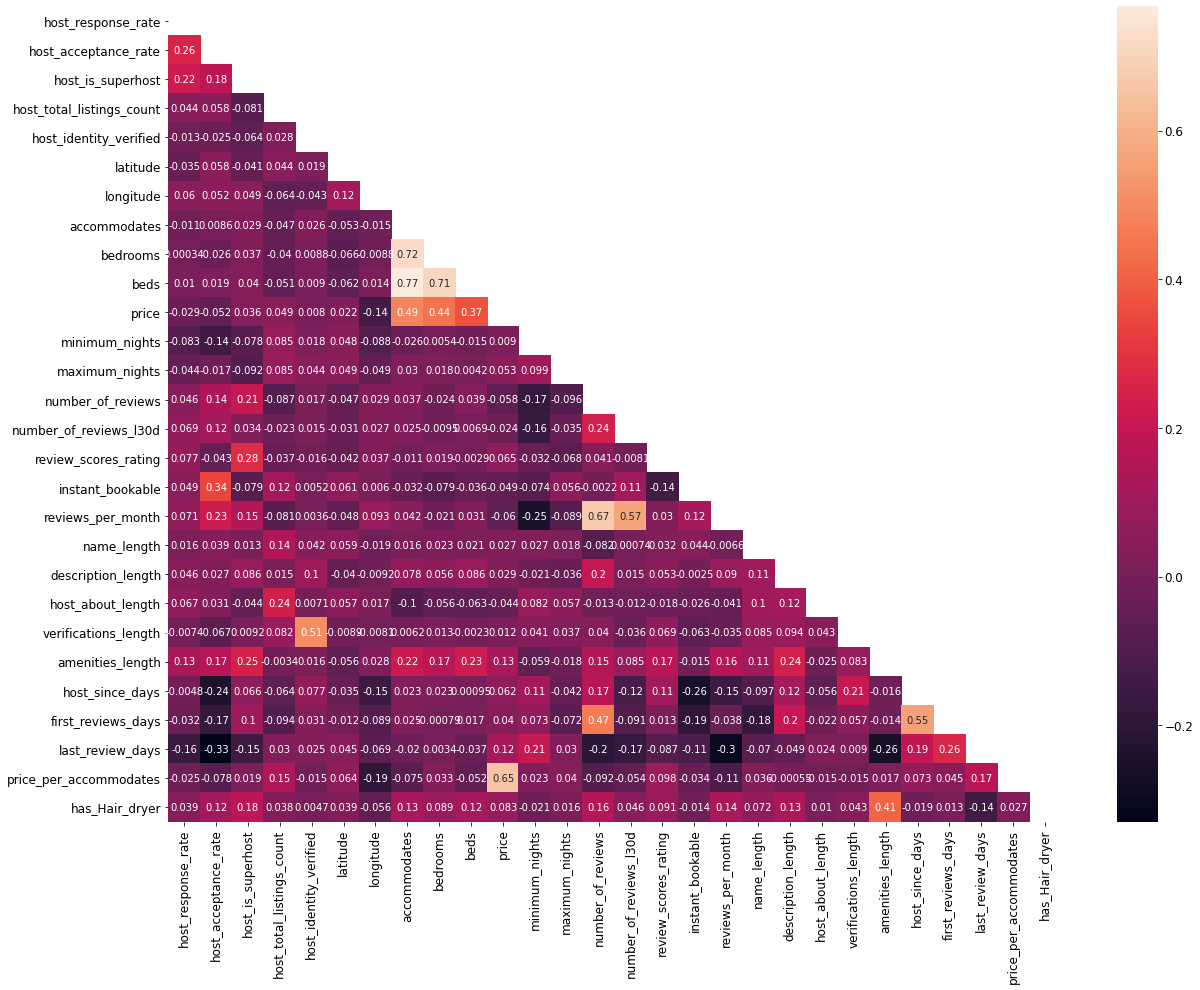

In [ ]:
#Plot the correlation plot among the numerical varaibles
import seaborn as sns
matrix = np.triu(df1.corr())
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df1.corr(), annot = True,mask=matrix)
plt.savefig("correlation_plot")
fig.show()

### 4. Split test and train sets

In [ ]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [ ]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set,test_set=split_train_test(df1,0.2)
print("The length of train set is: ",len(train_set))
print("The length of test set is: ",len(test_set))

The length of train set is:  6265
The length of test set is:  1566


In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
df1_with_id =df1.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(df1_with_id, 0.2, "index")

In [ ]:
test_set.head()

index last_scraped  ... price_per_accommodates has_Hair_dryer
2       5   2021-02-05  ...              41.500000              1
5      12   2021-02-05  ...              24.000000              1
7      16   2021-02-05  ...              23.333333              1
12     23   2021-02-05  ...              18.750000              0
13     25   2021-02-05  ...              40.500000              1

[5 rows x 43 columns]

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df1, test_size=0.2, random_state=42)

In [ ]:
test_set.head()

last_scraped  ... has_Hair_dryer
3171    2021-02-05  ...              0
20070   2021-02-05  ...              1
10877   2021-02-05  ...              1
5410    2021-02-05  ...              1
21701   2021-02-06  ...              0

[5 rows x 42 columns]

In [ ]:
df1["rating_cat"] = pd.cut(df1["review_scores_rating"],
                               bins=[19, 92, 96, 99, 101],
                               labels=[1, 2, 3, 4])

In [ ]:
df1["rating_cat"].value_counts()

2    2087
1    1967
3    1937
4    1840
Name: rating_cat, dtype: int64

- As shown below, Shuffle the dataset to avoid the bais batween the train and test sets by rearranging the order of items in a list randomly


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df1, df1["rating_cat"]):
    strat_train_set =df1.iloc[train_index,:]
    strat_test_set = df1.iloc[test_index,:]

In [ ]:
strat_train_set.head()

last_scraped  ... rating_cat
12882   2021-02-05  ...          2
20944   2021-02-05  ...          1
396     2021-02-06  ...          2
614     2021-02-05  ...          2
2516    2021-02-06  ...          1

[5 rows x 43 columns]

In [ ]:
strat_test_set.head()

last_scraped  ... rating_cat
21888   2021-02-06  ...          4
24686   2021-02-05  ...          3
23120   2021-02-06  ...          2
22501   2021-02-05  ...          4
17403   2021-02-05  ...          1

[5 rows x 43 columns]

# Discover and visualize the data to gain insights

### 1. Draw the word cloud for text variables

The word cloud for "description", <br>
which can help us to get the most popular words for hosts to describe thier Airbnb apartments.

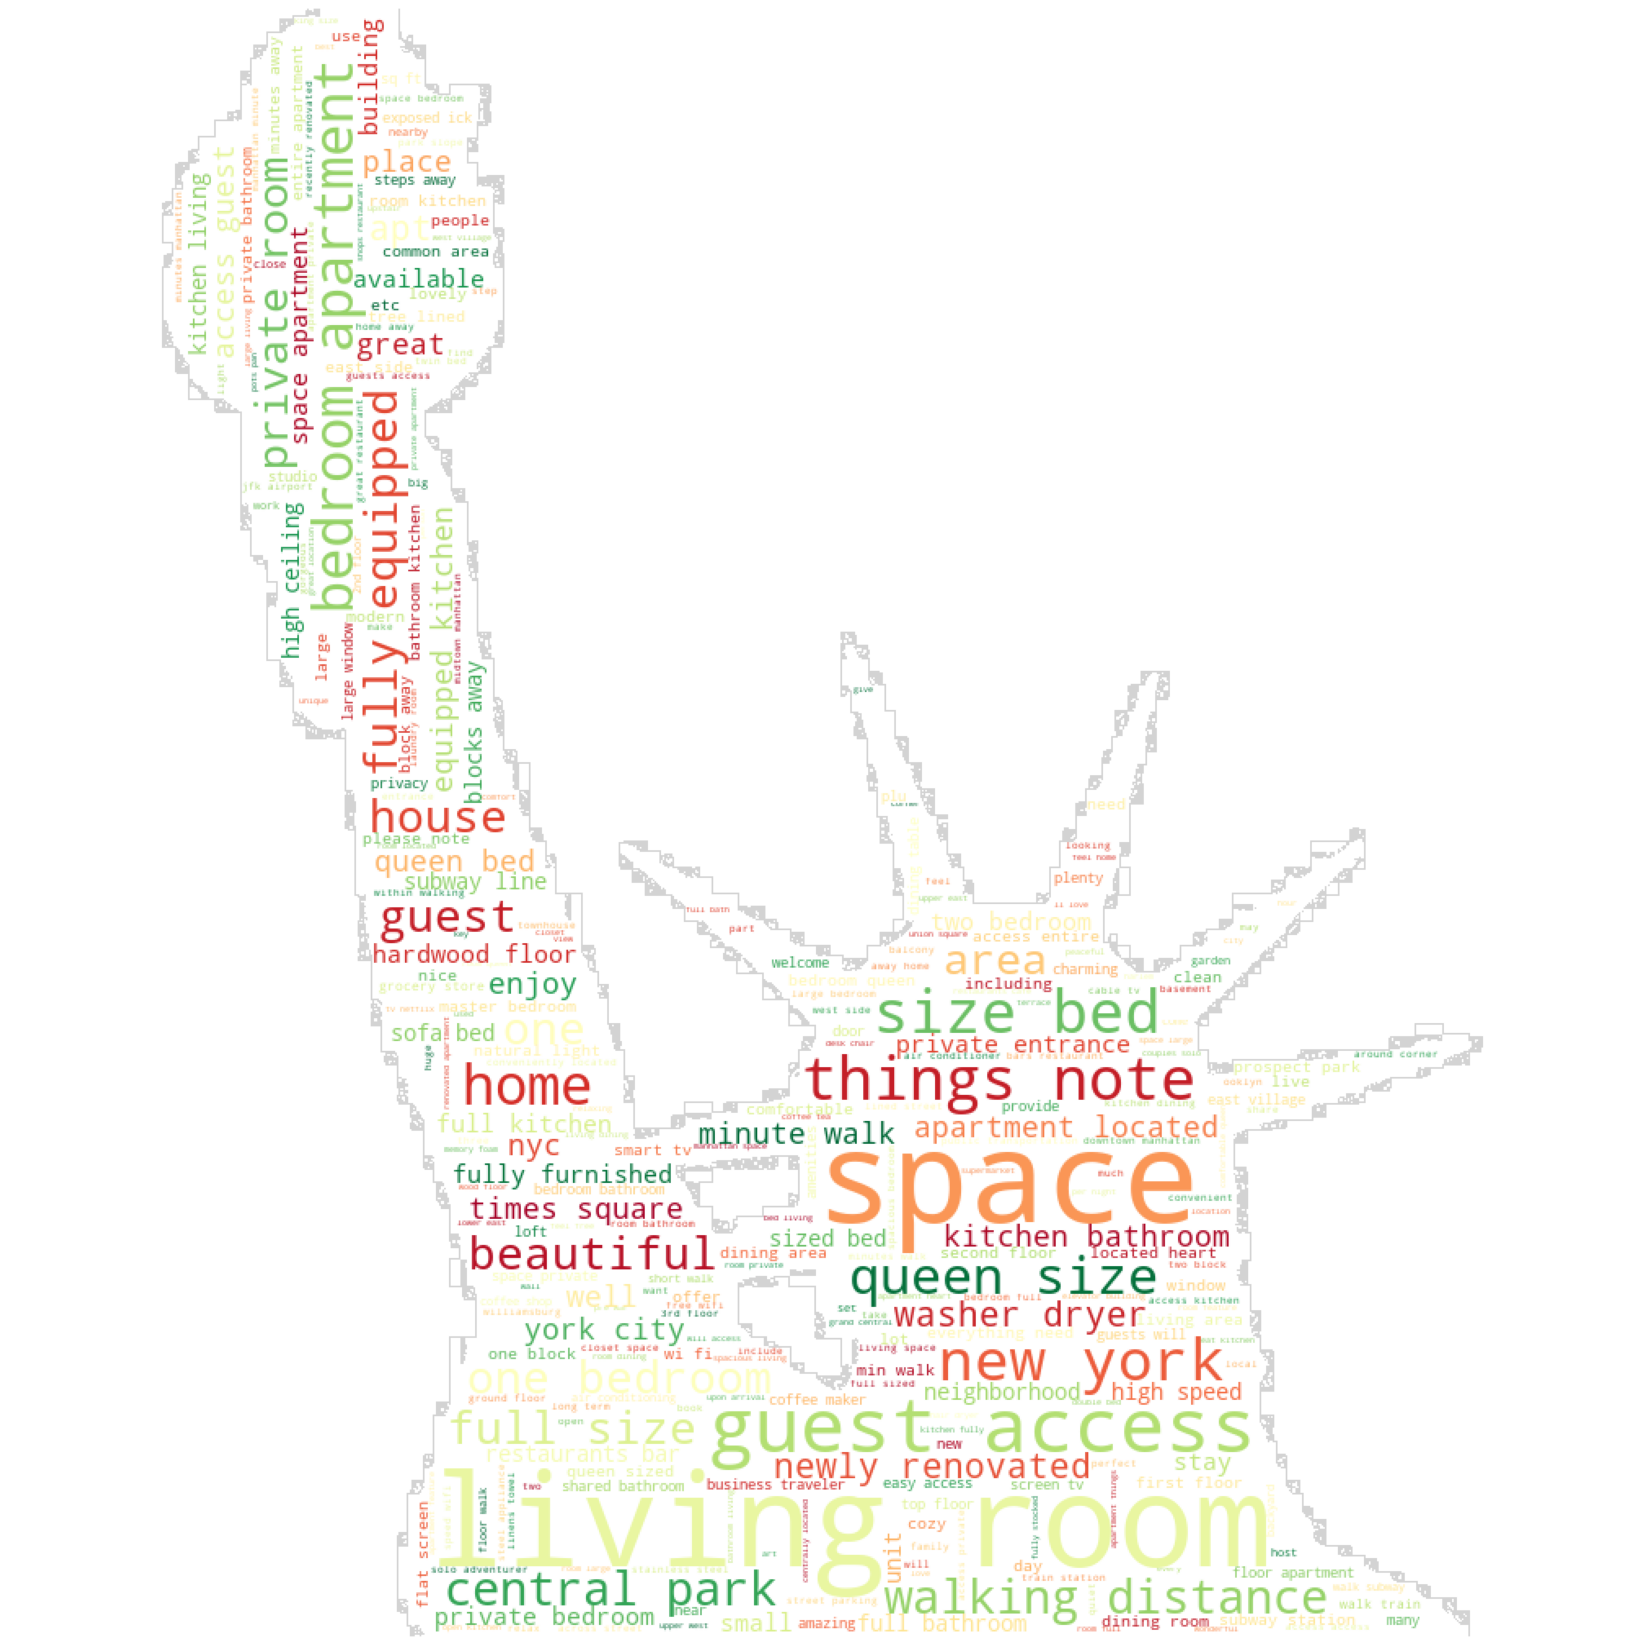

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from PIL import Image
comment_words = ' '
STOPWORDS.update(['/><br','br','&'])
stopwords = set(STOPWORDS)


sentences=''
for val in df1['description']: 

   # typecaste each val to string 
    val = str(val)
    sentences=val+sentences
   # split the value 
tokens=sentences.split()

# Converts each token into lowercase 
token=[element.lower() for element in tokens]

# for words in token: 
comment_words=" ".join(str(item) for item in token)
comment_words=comment_words.replace("br", "").replace('access to','access')\
.replace('you will','').replace('the apartment','apartment').replace('apartment is','apartment')
mask = np.array(Image.open("liberty_statue.jpg"))


wordcloud = WordCloud(width = 800, height =900 , 
            stopwords = stopwords, 
            max_words=800,
            background_color="white",
            colormap='RdYlGn',
            mask=mask,
            min_font_size = 5,                      
            collocations=True,
            contour_color='lightgrey',
            contour_width=1).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (50, 30)) 
plt.imshow(wordcloud) 

plt.axis("off") 
#plt.tight_layout(pad = 0) 
plt.savefig("wordcloud_desription.jpg")
plt.show()




The word cloud for "host_about", <br>
which can help us to get the most popular words for hosts to introduce themselves

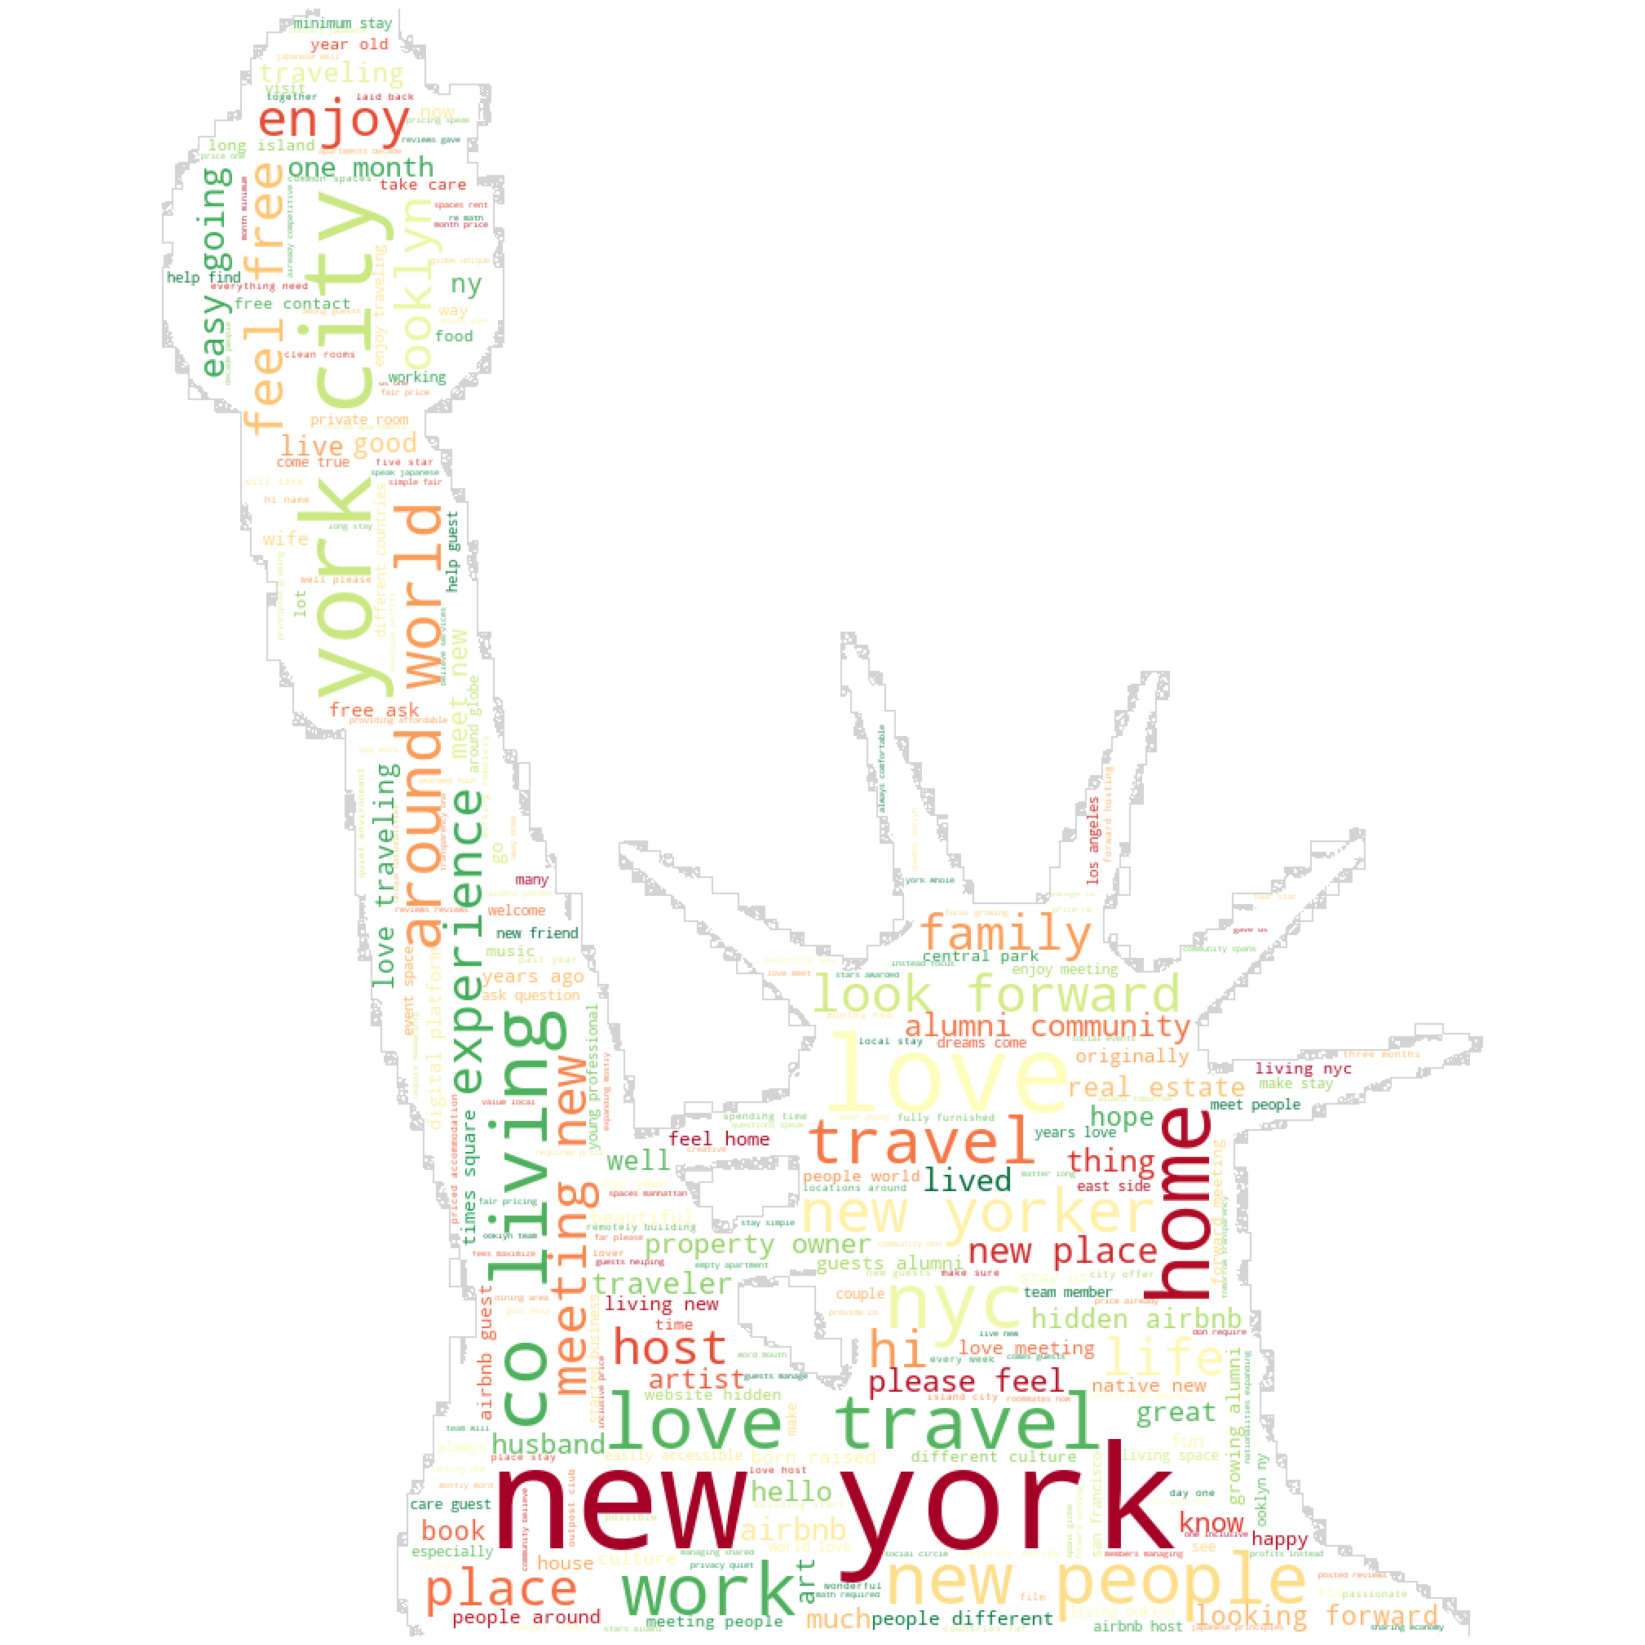

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from PIL import Image
comment_words = ' '
STOPWORDS.update(['/><br','br','&'])
stopwords = set(STOPWORDS)


sentences=''
for val in df1['host_about']: 

   # typecaste each val to string 
    val = str(val)
    sentences=val+sentences
   # split the value 
tokens=sentences.split()

# Converts each token into lowercase 
token=[element.lower() for element in tokens]

# for words in token: 
comment_words=" ".join(str(item) for item in token)
comment_words=comment_words.replace("br", "").replace('access to','access')\
.replace('you will','').replace('the apartment','apartment').replace('apartment is','apartment').replace('je suis','')
mask = np.array(Image.open("liberty_statue.jpg"))

image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(width = 800, height =900 , 
            stopwords = stopwords, 
            max_words=1000,
            background_color="white",
            colormap='RdYlGn',
            mask=mask,
            min_font_size = 5,                      
            collocations=True,
            contour_color='lightgrey',
            contour_width=1).generate(comment_words) 


# plot the WordCloud image                        
plt.figure(figsize = (50, 30)) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
plt.savefig("wordcloud_host_about")
plt.show()

The word cloud for "name", <br>
which can help us to get the most popular words for hosts to entitle thier Airbnb apartments.

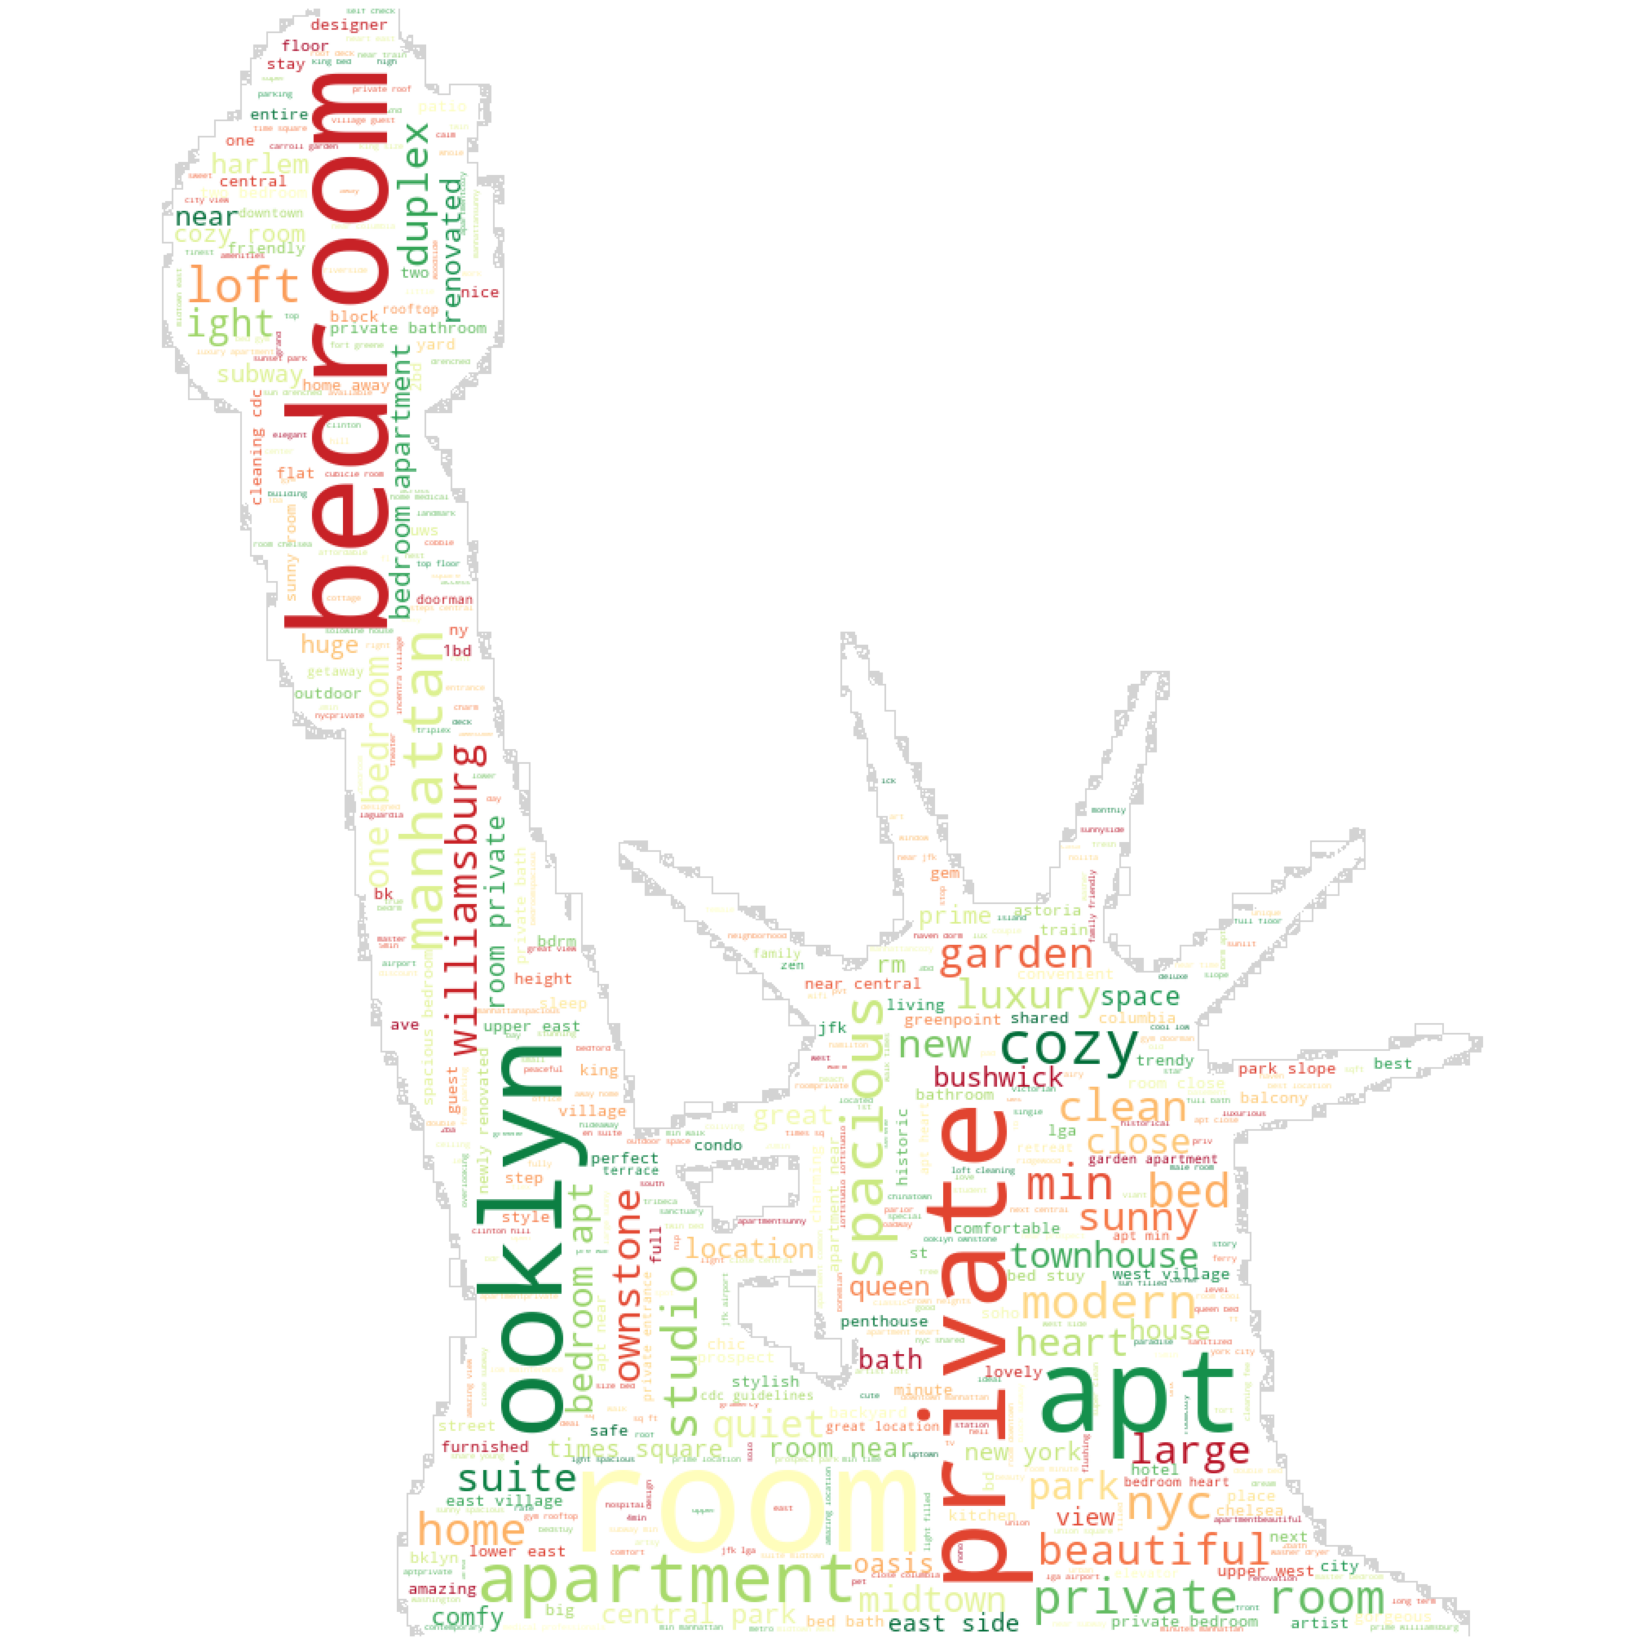

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from PIL import Image
comment_words = ' '
STOPWORDS.update(['/><br','br','&'])
stopwords = set(STOPWORDS)


sentences=''
for val in df1['name']: 

   # typecaste each val to string 
    val = str(val)
    sentences=val+sentences
   # split the value 
tokens=sentences.split()

# Converts each token into lowercase 
token=[element.lower() for element in tokens]

# for words in token: 
comment_words=" ".join(str(item) for item in token)
comment_words=comment_words.replace("br", "").replace('access to','access')\
.replace('you will','').replace('the apartment','apartment').replace('apartment is','apartment').replace('je suis','')
mask = np.array(Image.open("liberty_statue.jpg"))

image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(width = 800, height =900 , 
            stopwords = stopwords, 
            max_words=1000,
            background_color="white",
            colormap='RdYlGn',
            mask=mask,
            min_font_size = 5,                      
            collocations=True,
            contour_color='lightgrey',
            contour_width=1).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (50, 30)) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
plt.savefig("wordcloud_name")
plt.show()

### 2. Geographic Distribution

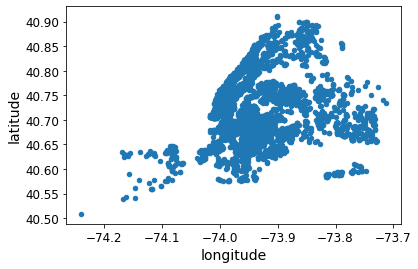

In [ ]:
df1.plot(kind="scatter", x="longitude", y="latitude")
plt.savefig("bad_visualization_plot")

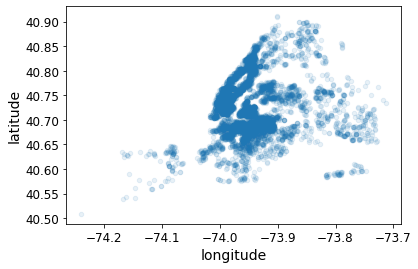

In [ ]:
df1.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.savefig("better_visualization_plot")

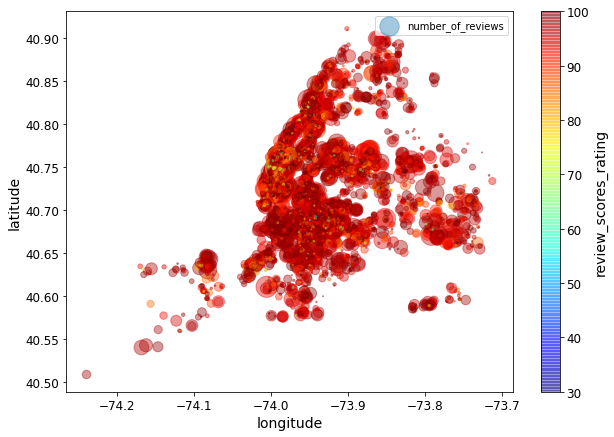

In [ ]:
df1.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=df1["number_of_reviews"], label="number_of_reviews", figsize=(10,7),
    c="review_scores_rating", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.savefig("Airbnb_review_rating_scatterplot")

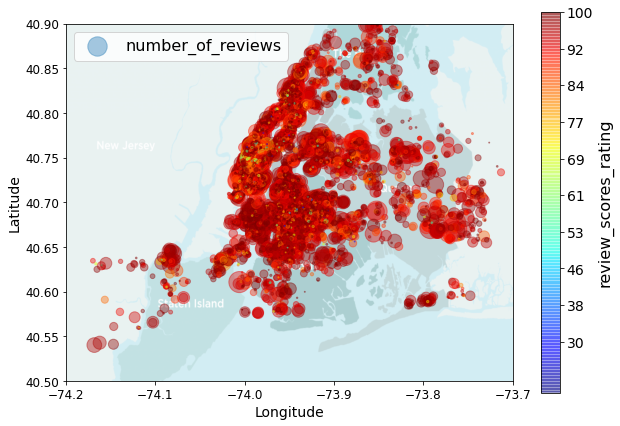

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread('map_nyc.png')
ax = df1.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=df1["number_of_reviews"], label="number_of_reviews",
                       c="review_scores_rating", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-74.2, -73.7, 40.5, 40.90], alpha=0.4,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

rating = df1["review_scores_rating"]
tick_values = np.linspace(rating.min(), rating.max(), 10)
cbar = plt.colorbar(ticks=tick_values/rating.max())
cbar.ax.set_yticklabels([(round(v)) for v in tick_values], fontsize=14)
cbar.set_label('review_scores_rating', fontsize=16)

plt.legend(fontsize=16)
plt.savefig("Montreal_Airbnb_review_rating_scatterplot")
plt.show()

### 3. Get the correlation value between target variable ("review_scores_rating") and other predictors

In [ ]:
corr_matrix2 = df1.corr()

In [ ]:
corr_matrix2["review_scores_rating"].sort_values(ascending=False)

review_scores_rating         1.000000
host_is_superhost            0.278963
amenities_length             0.167810
host_since_days              0.111430
price_per_accommodates       0.097599
has_Hair_dryer               0.090977
host_response_rate           0.077282
verifications_length         0.068575
price                        0.064726
description_length           0.053203
number_of_reviews            0.041081
longitude                    0.036754
name_length                  0.031783
reviews_per_month            0.029780
bedrooms                     0.018988
first_reviews_days           0.012917
beds                        -0.002879
number_of_reviews_l30d      -0.008087
accommodates                -0.010573
host_identity_verified      -0.016329
host_about_length           -0.017769
minimum_nights              -0.031950
host_total_listings_count   -0.036696
latitude                    -0.041689
host_acceptance_rate        -0.043134
maximum_nights              -0.068417
last_review_

In [ ]:
corr_matrix["review_scores_rating"].sort_values(ascending=False)

review_scores_rating         1.000000
number_of_reviews            0.054595
reviews_per_month            0.041548
bedrooms                     0.010334
number_of_reviews_l30d       0.005152
accommodates                -0.006905
beds                        -0.011301
maximum_nights              -0.013451
longitude                   -0.015705
minimum_nights              -0.025785
latitude                    -0.031618
host_total_listings_count   -0.032321
Name: review_scores_rating, dtype: float64

### Compare the correlation value before and after adding new features, we can see that the new feature of "amenities_length","price_per_accommodates" and "has_hair_dryer" are all the predictors have the high correlation with the target variable

### 4. Draw the scatter matrix plot for the top 4 correlated varibles with review_scores_rating

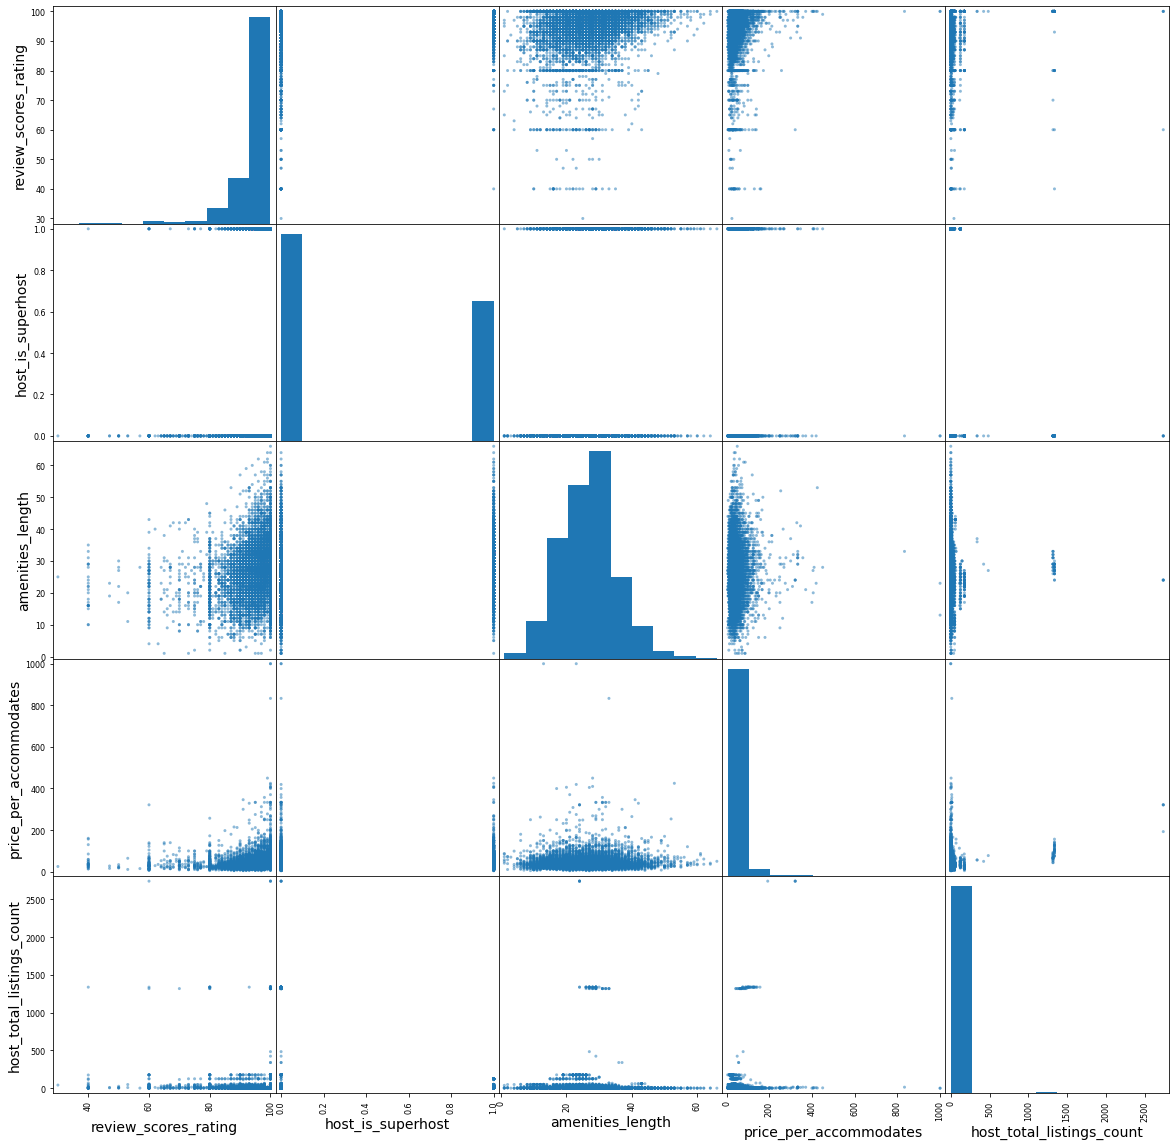

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["review_scores_rating", "host_is_superhost", "amenities_length",
              "price_per_accommodates",'host_total_listings_count']
scatter_matrix(df1[attributes], figsize=(20, 20))
plt.savefig("scatter_matrix_plot")

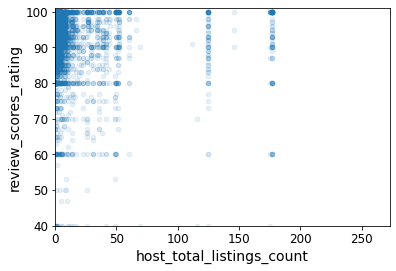

In [ ]:
df1.plot(kind="scatter", x="host_total_listings_count", y="review_scores_rating",
             alpha=0.1)
plt.axis([0, 273, 40, 101])
plt.savefig("listing_counts_vs_rating_scatterplot")

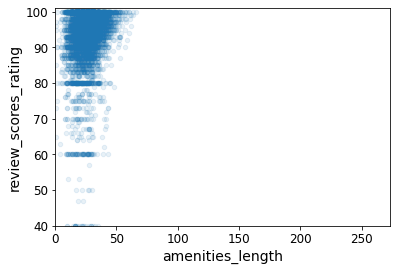

In [ ]:
df1.plot(kind="scatter", x="amenities_length", y="review_scores_rating",
             alpha=0.1)
plt.axis([0, 273, 40, 101])
plt.savefig("income_vs_house_value_scatterplot")

In [ ]:
df1.describe()

host_response_rate  ...  has_Hair_dryer
count         7831.000000  ...     7831.000000
mean             0.918087  ...        0.807432
std              0.204328  ...        0.394342
min              0.000000  ...        0.000000
25%              0.960000  ...        1.000000
50%              1.000000  ...        1.000000
75%              1.000000  ...        1.000000
max              1.000000  ...        1.000000

[8 rows x 28 columns]

In [ ]:
df=pd.read_csv('listings_ny_with_starbucks_data.zip')

In [ ]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

# Starbucks Effect with Price per accomodate and number of Airbnb

In [35]:
import pandas as pd
df_starbucks=pd.read_csv('ny_directory_citywise.csv')

df_starbucks[70:]

city  starbucks_count
70         great neck                2
71             greece                2
72          greenvale                1
73        guilderland                1
74       hampton bays                1
..                ...              ...
208          woodbury                1
209          woodside                1
210           yonkers                6
211  yorktown heights                1
212       Grand Total              645

[143 rows x 2 columns]

In [40]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 5.4MB/s 
     |████████████████████████████████| 6.5MB 13.0MB/s 
     |████████████████████████████████| 14.8MB 272kB/s 


In [41]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [45]:
df_airbnb=pd.read_csv(('http://data.insideairbnb.com/united-states/ny/new-york-city/2021-02-04/data/listings.csv.gz'))

In [137]:
df_airbnb['neighbourhood_group_cleansed'].value_counts()
df1.groupby('neighbourhood_group_cleansed')['price_per_accommodates'].mean()


neighbourhood_group_cleansed
Bronx            31.931346
Brooklyn         39.969895
Manhattan        55.442396
Queens           32.435165
Staten Island    28.970564
Name: price_per_accommodates, dtype: float64

In [43]:
df_places = gpd.read_file('new-york.geojson')

In [96]:
df_places

name  ...  airbnb_num
0  Staten Island  ...         289
1         Queens  ...        4704
2       Brooklyn  ...       14474
3      Manhattan  ...       16553
4          Bronx  ...         992

[5 rows x 6 columns]

In [48]:
df_places['airbnb_num']=[289,4704,14474,16553,992]

In [101]:
# reference: https://nycfuture.org/research/state-of-the-chains-2017
df_places['starbucks_num']=[36,50,50,223,50]

In [138]:
#Average price per accommodates
df_places['price_per_acc']=[28.97,32.44,39.97,55.44,31.93]


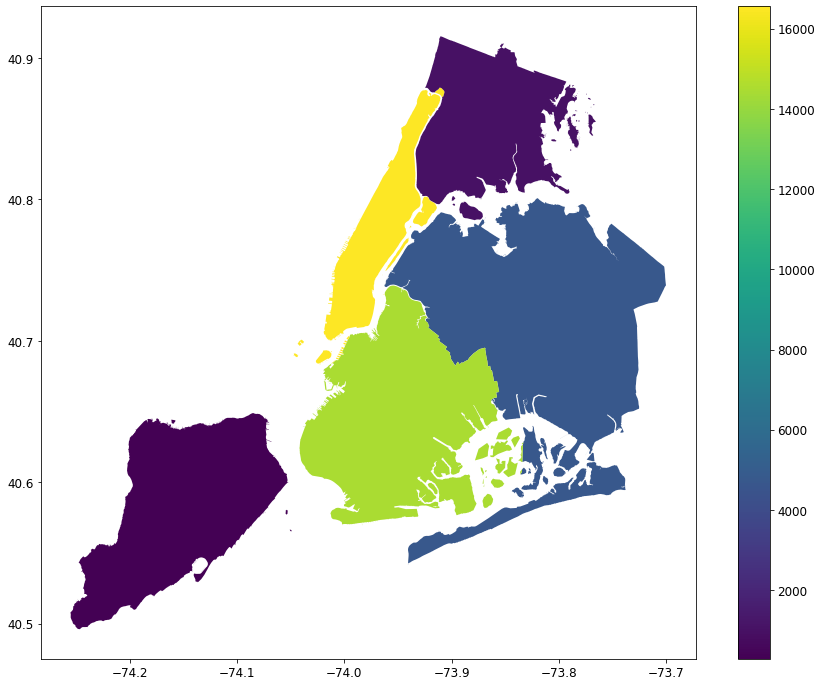

In [102]:
f, ax = plt.subplots(1, figsize=(15, 12))
ax =df_places.plot(column='airbnb_num',ax=ax,legend=True)

plt.show()

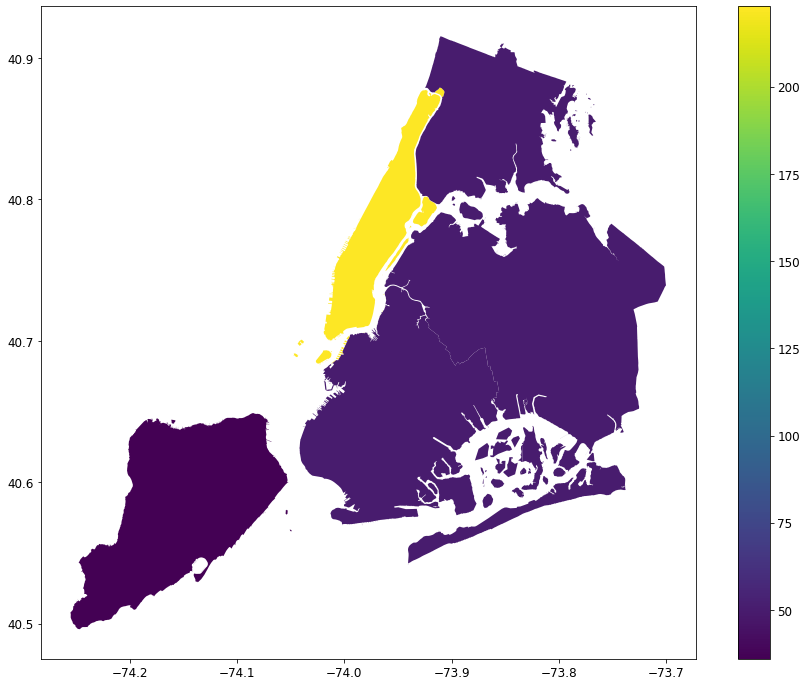

In [103]:
f, ax = plt.subplots(1, figsize=(15, 12))
ax =df_places.plot(column='starbucks_num',ax=ax,legend=True)

plt.show()

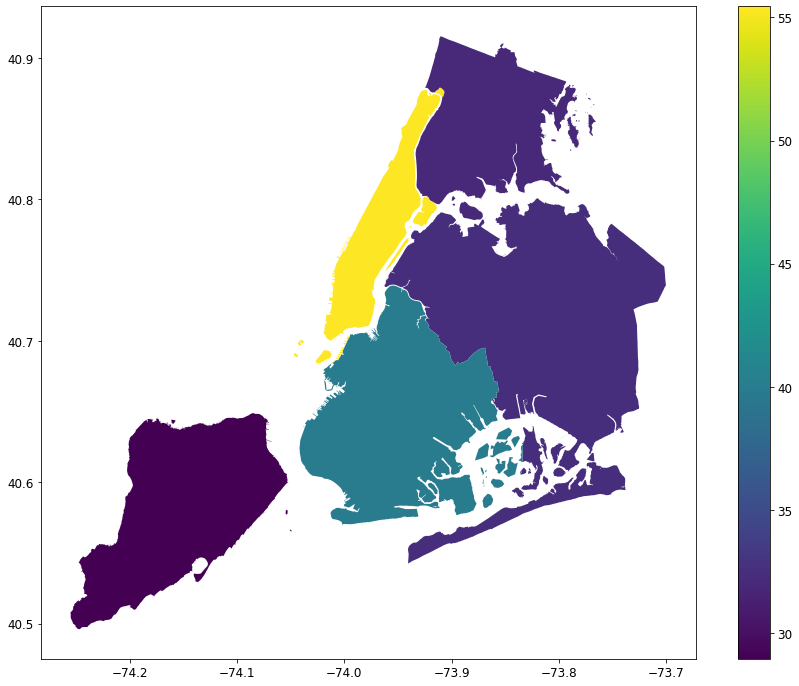

In [139]:
f, ax = plt.subplots(1, figsize=(15, 12))
ax =df_places.plot(column='price_per_acc',ax=ax,legend=True)

plt.show()

In [ ]:
#https://www.grubstreet.com/2010/06/what_are_there_more_of_in_manh.html#:~:text=According%20to%20Subway's%20%E2%80%9CRestaurant%E2%80%9D%20Locator,transfer%20stations%20as%20just%20one)